In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# allow for .py files in canine package to be added
import sys
sys.path.insert(0, '../')

from canine.preprocessing import datahandler
from canine.plotting import results

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# used to reload .py files in src directory
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# only show error messages from tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

VOL = '/mnt/data1/stock/misc/canine'
DSIZE = (224, 224) # (32, 32)
NPY_IMAGE_PATH = os.path.join(VOL, f'images_{DSIZE[0]}x{DSIZE[1]}.npy')
NPY_LABEL_PATH = os.path.join(VOL, f'labels.npy')

gpus = tf.config.get_visible_devices('GPU')
for i, device in enumerate(gpus):
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
# !nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Data Loader

In [ ]:
# (optional) save the data to an np.array 

datahandler.save_data(VOL, NPY_IMAGE_PATH, NPY_LABEL_PATH, DSIZE)

In [34]:
images, labels, class_labels = datahandler.load_data(NPY_IMAGE_PATH, NPY_LABEL_PATH, 
                                                     normalize=True, remove_undefined=False)

Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest = datahandler.partition_data(images, labels, 
                                                                           partition=(0.6,0.2,0.2), 
                                                                           shuffle=True)

print(class_labels)
print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

['lying' 'sitting' 'standing' 'undefined']
(12347, 224, 224, 3) (12347, 1) (4116, 224, 224, 3) (4116, 1) (4114, 224, 224, 3) (4114, 1)


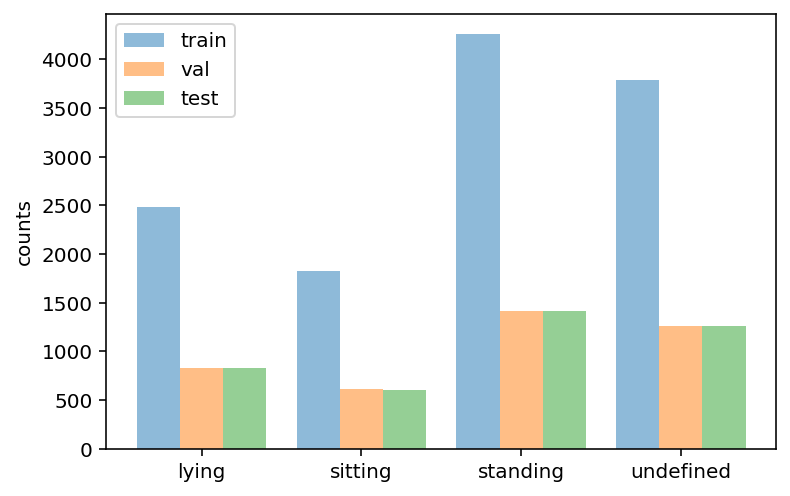

In [35]:
ind = np.arange(len(class_labels))
width = 0.27 # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

_, counts = np.unique(Ttrain, return_counts=True)
rects1 = ax.bar(ind, counts, width, alpha=0.5)
_, counts = np.unique(Tvalidate, return_counts=True)
rects2 = ax.bar(ind+width, counts, width, alpha=0.5)
_, counts = np.unique(Ttest, return_counts=True)
rects3 = ax.bar(ind+width*2, counts, width, alpha=0.5)

ax.set_ylabel('counts')
ax.set_xticks(ind+width)
ax.set_xticklabels(class_labels)
ax.legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

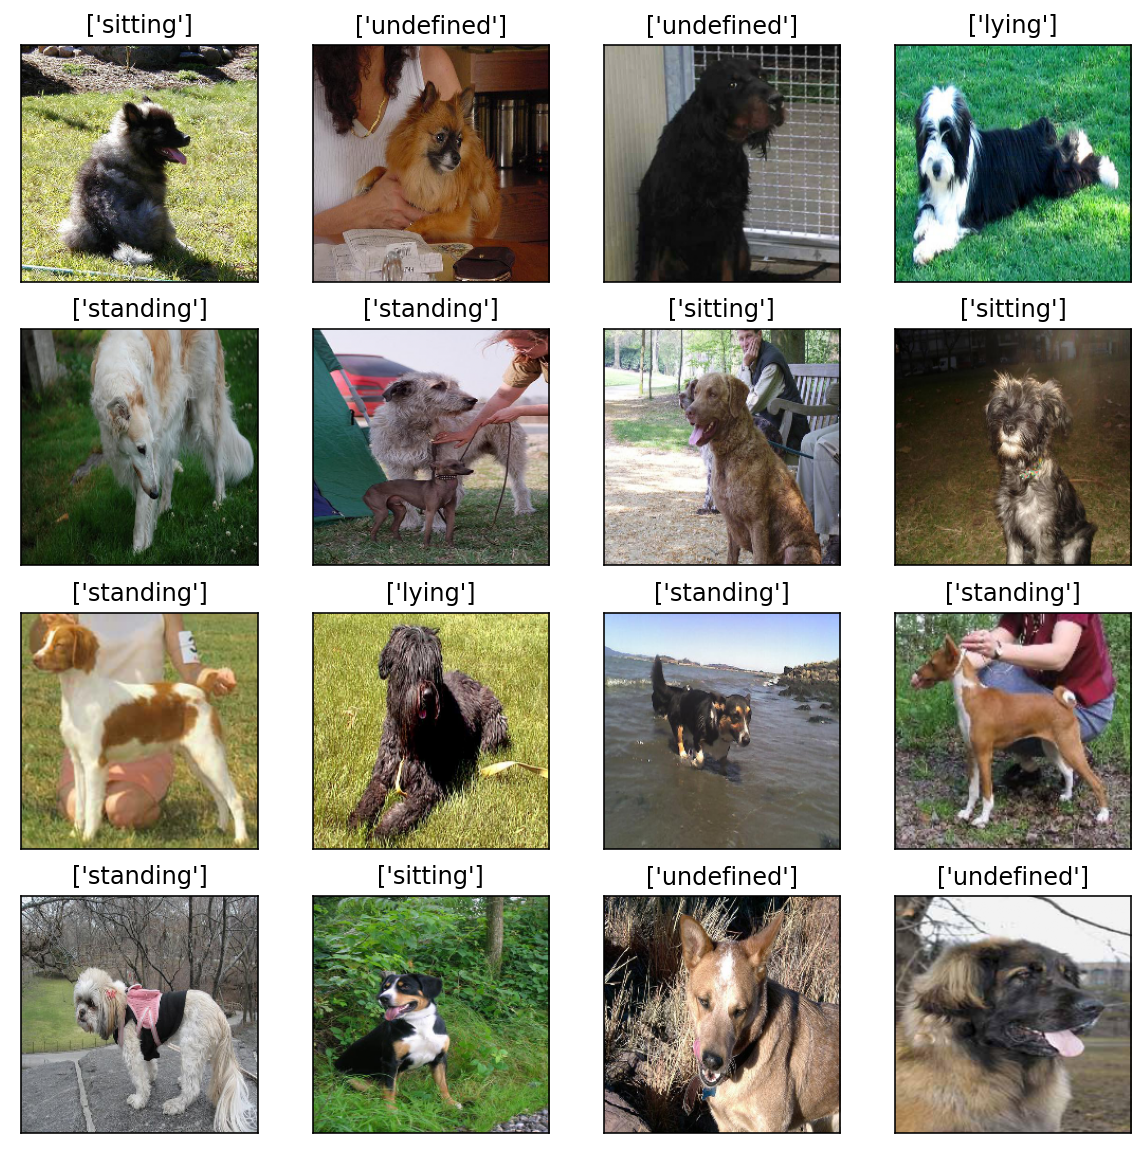

In [36]:
h, w = 4, 4
fig, axs = plt.subplots(h, w, figsize=(10, 10))
axs = axs.ravel()
for i in range(h*w):
    axs[i].imshow(Xtrain[i])
    axs[i].set_title(class_labels[Ttrain[i]])
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Basic Model

In [37]:
tf.keras.backend.clear_session()

epochs = 100
batch_size = 32
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
n_units_in_conv_layers = [32, 32, 64, 128]
kernels_size_and_stride = [(3, 1)]*len(n_units_in_conv_layers)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.10),
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
], name='augmentation')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:])
Z = data_augmentation(Z)
for (kernel, stride), units in zip(kernels_size_and_stride, n_units_in_conv_layers):
    Z = tf.keras.layers.Conv2D(
        units, kernel_size=kernel, strides=stride, padding='same')(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation('relu')(Z)
    Z = tf.keras.layers.MaxPooling2D(pool_size=2)(Z)
    Z = tf.keras.layers.Dropout(0.20)(Z)

Z = tf.keras.layers.Dense(128, activation='relu')(tf.keras.layers.Flatten()(Z))
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(inputs=X, outputs=Y)

model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
                                              patience=5)]

start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/100
386/386 - 58s - loss: 1.3649 - accuracy: 0.4070 - val_loss: 1.3105 - val_accuracy: 0.4312
Epoch 2/100
386/386 - 13s - loss: 1.2686 - accuracy: 0.4424 - val_loss: 1.2484 - val_accuracy: 0.4529
Epoch 3/100
386/386 - 13s - loss: 1.2406 - accuracy: 0.4596 - val_loss: 1.2218 - val_accuracy: 0.4789
Epoch 4/100
386/386 - 14s - loss: 1.2180 - accuracy: 0.4684 - val_loss: 1.2398 - val_accuracy: 0.4772
Epoch 5/100
386/386 - 14s - loss: 1.2100 - accuracy: 0.4774 - val_loss: 1.2406 - val_accuracy: 0.4577
Epoch 6/100
386/386 - 15s - loss: 1.1999 - accuracy: 0.4776 - val_loss: 1.2093 - val_accuracy: 0.4801
Epoch 7/100
386/386 - 14s - loss: 1.1894 - accuracy: 0.4830 - val_loss: 1.2826 - val_accuracy: 0.4278
Epoch 8/100
386/386 - 13s - loss: 1.1825 - accuracy: 0.4882 - val_loss: 1.2129 - val_accuracy: 0.4657
Epoch 9/100
386/386 - 13s - loss: 1.1739 - accuracy: 0.4944 - val_loss: 1.2194 - val_accuracy: 0.4611
Epoch 10/100
386/386 - 13s - loss: 1.1695 - accuracy: 0.4934 - val_loss: 1.2218 - 

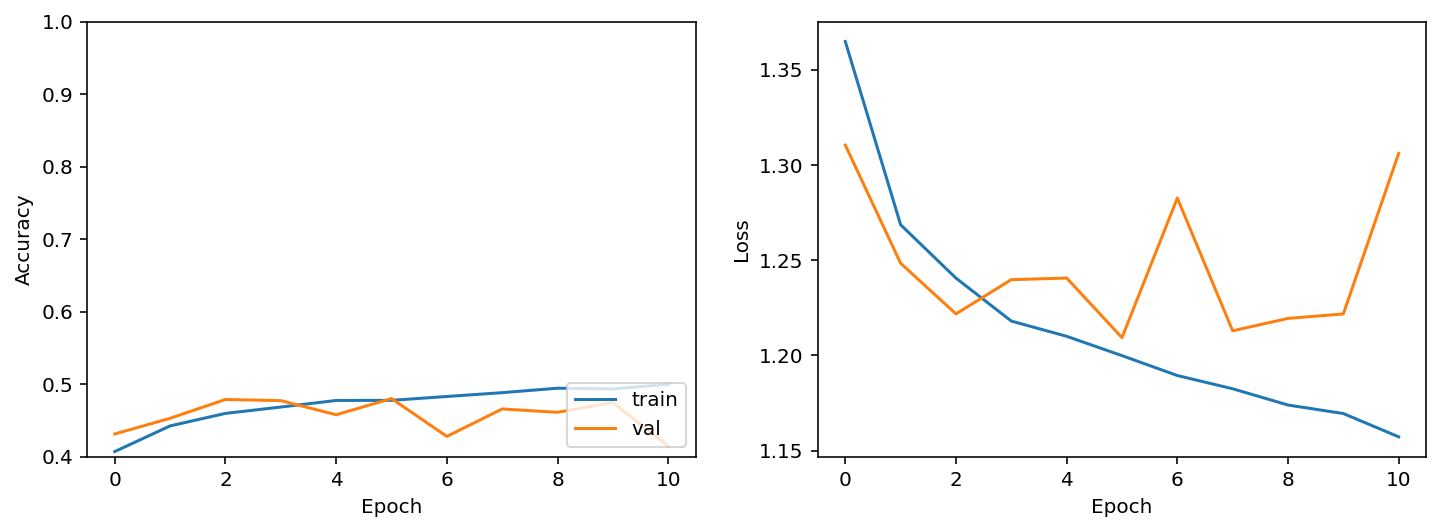

In [38]:
results.plot_history(history)

In [39]:
model.evaluate(Xtest, Ttest);

129/129 [==============================] - 13s 104ms/step - loss: 1.2947 - accuracy: 0.4290


In [40]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2    3
    ------------------------
 0 | 32.2  2.8 53.0 12.0
 1 | 18.5  4.6 63.9 13.0
 2 | 13.8  1.4 80.0  4.7
 3 | 38.0  2.8 32.7 26.6

 0 lying, 1 sitting, 2 standing, 3 undefined


# Transfer Learning

In [8]:
# DON'T NORMALIZE for MobileNet / ResNet (use custom preprocessing layer)
# Requires shape of images to be (None, 224, 224, 3)
#
images, labels, class_labels = datahandler.load_data(NPY_IMAGE_PATH, NPY_LABEL_PATH, 
                                                     normalize=False, remove_undefined=False)

Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest = datahandler.partition_data(images, labels, 
                                                                           partition=(0.75,0.15,0.1), 
                                                                           shuffle=True)

print(class_labels)
print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

['lying' 'sitting' 'standing' 'undefined']
(15433, 224, 224, 3) (15433, 1) (3087, 224, 224, 3) (3087, 1) (2057, 224, 224, 3) (2057, 1)


## MobileNetV2

In [7]:
tf.keras.backend.clear_session()

epochs = 15
batch_size = 32

base_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=base_shape,
                                               include_top=False,
                                               weights='imagenet')

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
], name='augmentation')

preprocess_input = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda X: 
        tf.keras.applications.mobilenet_v2.preprocess_input(X))
], name='preprocess')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:], name='input')
Z = preprocess_input(tf.cast(Z, tf.float32))
Z = data_augmentation(Z)

Z = base_model(Z, training=True)

Z = tf.keras.layers.GlobalAveragePooling2D()(Z)
Z = tf.keras.layers.Dropout(0.2)(Z)
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(X, Y, name='MobileNetV2-Dog')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
                     
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)]
    
start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/15
268/268 - 116s - loss: 0.9659 - accuracy: 0.5503 - val_loss: 0.7664 - val_accuracy: 0.6550
Epoch 2/15
268/268 - 31s - loss: 0.7531 - accuracy: 0.6696 - val_loss: 0.6525 - val_accuracy: 0.7163
Epoch 3/15
268/268 - 32s - loss: 0.6522 - accuracy: 0.7207 - val_loss: 0.5877 - val_accuracy: 0.7513
Epoch 4/15
268/268 - 31s - loss: 0.5874 - accuracy: 0.7469 - val_loss: 0.5476 - val_accuracy: 0.7636
Epoch 5/15
268/268 - 31s - loss: 0.5452 - accuracy: 0.7676 - val_loss: 0.5136 - val_accuracy: 0.7846
Epoch 6/15
268/268 - 31s - loss: 0.4994 - accuracy: 0.7969 - val_loss: 0.4906 - val_accuracy: 0.7944
Epoch 7/15
268/268 - 31s - loss: 0.4613 - accuracy: 0.8136 - val_loss: 0.4705 - val_accuracy: 0.8091
Epoch 8/15
268/268 - 31s - loss: 0.4351 - accuracy: 0.8223 - val_loss: 0.4555 - val_accuracy: 0.8168
Epoch 9/15
268/268 - 31s - loss: 0.4033 - accuracy: 0.8367 - val_loss: 0.4455 - val_accuracy: 0.8214
Epoch 10/15
268/268 - 31s - loss: 0.3839 - accuracy: 0.8471 - val_loss: 0.4364 - val_accur

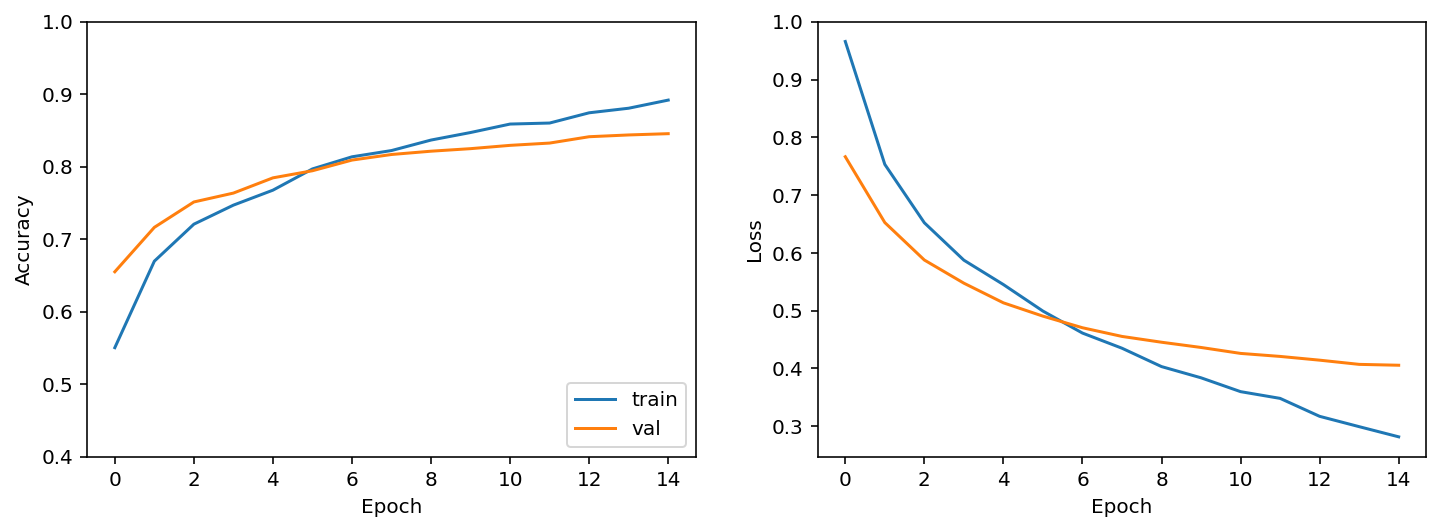

In [9]:
results.plot_history(history)

In [10]:
model.evaluate(Xtest, Ttest);

90/90 [==============================] - 40s 449ms/step - loss: 0.4106 - accuracy: 0.8398


[0.41057345271110535, 0.8398177623748779]

In [ ]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

## ResNet50V2

In [9]:
tf.keras.backend.clear_session()

epochs = 5
batch_size = 32

base_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(input_shape=base_shape,
                                               include_top=False,
                                               weights='imagenet')

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
], name='augmentation')

preprocess_input = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda X: 
        tf.keras.applications.resnet_v2.preprocess_input(X))
], name='preprocess')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:], name='input')
Z = preprocess_input(tf.cast(Z, tf.float32))
Z = data_augmentation(Z)

Z = base_model(Z, training=True)

Z = tf.keras.layers.GlobalAveragePooling2D()(Z)
Z = tf.keras.layers.Dropout(0.2)(Z)
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(X, Y, name='ResNet50V2-Dog')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
                     
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)]
    
start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/5
483/483 - 238s - loss: 1.0829 - accuracy: 0.5488 - val_loss: 0.8375 - val_accuracy: 0.6767
Epoch 2/5
483/483 - 92s - loss: 0.7783 - accuracy: 0.6938 - val_loss: 0.7144 - val_accuracy: 0.7285
Epoch 3/5
483/483 - 93s - loss: 0.6626 - accuracy: 0.7435 - val_loss: 0.6758 - val_accuracy: 0.7473
Epoch 4/5
483/483 - 91s - loss: 0.5862 - accuracy: 0.7764 - val_loss: 0.6450 - val_accuracy: 0.7574
Epoch 5/5
483/483 - 92s - loss: 0.5263 - accuracy: 0.7989 - val_loss: 0.6281 - val_accuracy: 0.7626
Finished in 712.974 seconds.


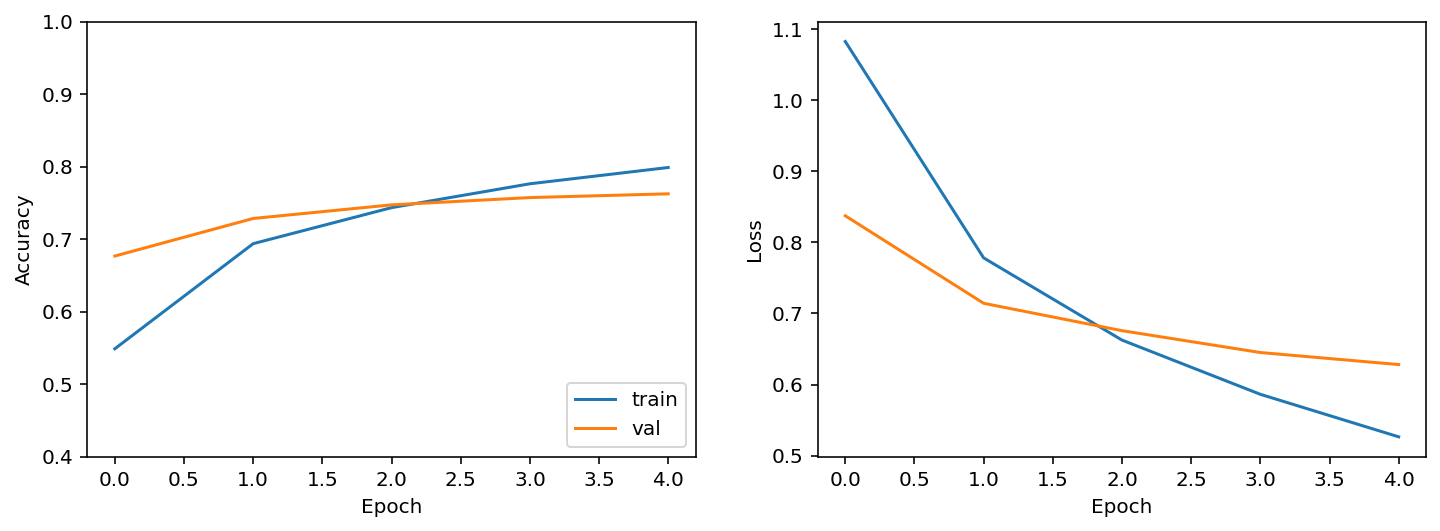

In [10]:
results.plot_history(history)

In [11]:
model.evaluate(Xtest, Ttest);

65/65 [==============================] - 4s 56ms/step - loss: 0.5639 - accuracy: 0.7900


[0.5638988018035889, 0.7899854183197021]

In [33]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2    3
    ------------------------
 0 | 77.3  2.4  5.1 15.2
 1 | 13.2 55.9  8.6 22.4
 2 |  2.4  4.2 87.3  6.1
 3 |  7.9  4.6  5.5 81.9

 0 lying, 1 sitting, 2 standing, 3 undefined
